In [1]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
# from dpm.models.vae import BernoulliVAE
from dpm.models import VAE
from dpm.visualize import plot_stats
import torch

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [3]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
x_train = X_scaled[:5000]
y_train = y[:5000]
x_train.shape, y_train.shape

((5000, 784), (5000,))

In [5]:
x_train.min()

0.0

In [6]:
x_train = torch.tensor(x_train).float()
x_train.size()

torch.Size([5000, 784])

In [7]:
x_train.sum()

tensor(510486.3750)

In [8]:
from dpm.distributions import Distribution, ConditionalModel, Normal, Bernoulli, Data
from functools import partial
from dpm.utils import Sigmoid, SafeSoftplus
from torch.nn.functional import softplus
# from dpm.train import train
# from dpm.criterion import cross_entropy

# # Pass Data to encoder -> mu, sigma
# # Sample from latent(mu, sigma)
# # Pass z to decoder -> Get Reconstruction

# # Maximize reconstruction Prob


# class VAE(Distribution):
    
#     def __init__(self, encoder_args={}, decoder_args={}, prior=None):
#         super().__init__()
#         preset_encoder_args={'input_dim':1, 'hidden_sizes':[24, 24],
#                              'activation':'ReLU', 'output_shapes':[1, 1],
#                              'output_activations':[None, 'Softplus'],
#                              'distribution':partial(Normal, learnable=False)}
#         preset_decoder_args={'input_dim':1, 'hidden_sizes':[24, 24],
#                              'activation':'ReLU', 'output_shapes':[1],
#                              'output_activations':[Sigmoid()],
#                              'distribution':partial(Bernoulli, learnable=False)}
        
#         preset_encoder_args.update(encoder_args)
#         preset_decoder_args.update(decoder_args)
        
#         self.encoder = ConditionalModel(**preset_encoder_args)
#         self.decoder = ConditionalModel(**preset_decoder_args)
        
#         self.prior = prior
#         if prior is None:
#             latent_dim = preset_decoder_args['input_dim']
#             self.prior = Normal(torch.zeros(latent_dim), 
#                                 torch.ones(latent_dim), 
#                                 learnable=False)
        
        
#     def log_prob(self, X):
#         Z, encoder_probs = self.encoder.sample(X, compute_logprob=True)
#         prior_probs = self.prior.log_prob(Z)
#         decoder_log_probs = self.decoder.log_prob(X, Z)
#         return decoder_log_probs + prior_probs - encoder_probs
    
    
#     def sample(self, batch_size, compute_logprob=False):
#         Z = self.prior.sample(batch_size)
#         return self.decoder.sample(Z, compute_logprob)
    
    
#     def fit(self, x, **kwargs):
#         data = Data(x)
#         stats = train(data, self, cross_entropy, **kwargs)
#         return stats
        


In [9]:
torch.manual_seed(42)

In [10]:
# model.fit(x_train)
model = VAE({'input_dim':784, 'hidden_sizes':[512, 128], 'output_shapes':[64, 64]}, 
            {'input_dim':64, 'hidden_sizes':[128, 512], 'output_shapes':[784, 784],
             'output_activations':[None, SafeSoftplus()],
             'distribution':partial(Normal, learnable=False)}, 
             prior=Normal(torch.zeros(64), torch.ones(64), learnable=False))
stats=None

In [11]:
x_train.mean()

tensor(0.1302)

In [14]:
stats = model.fit((x_train - x_train.mean()) / x_train.std(), use_elbo=True, 
                  epochs=1000, log_interval=10, batch_size=64, 
                  stats=stats)

[Epoch 0/1000]	Loss 1201.84
[Epoch 10/1000]	Loss 729.86
[Epoch 20/1000]	Loss 504.98
[Epoch 30/1000]	Loss 420.32
[Epoch 40/1000]	Loss 394.31
[Epoch 50/1000]	Loss 378.68
[Epoch 60/1000]	Loss 335.69
[Epoch 70/1000]	Loss 350.90
[Epoch 80/1000]	Loss 376.67
[Epoch 90/1000]	Loss 318.99
[Epoch 100/1000]	Loss 339.13
[Epoch 110/1000]	Loss 328.55
[Epoch 120/1000]	Loss 342.80
[Epoch 130/1000]	Loss 314.72
[Epoch 140/1000]	Loss 345.89
[Epoch 150/1000]	Loss 328.04
[Epoch 160/1000]	Loss 293.35
[Epoch 170/1000]	Loss 291.64
[Epoch 180/1000]	Loss 337.23
[Epoch 190/1000]	Loss 330.42
[Epoch 200/1000]	Loss 308.78
[Epoch 210/1000]	Loss 313.01
[Epoch 220/1000]	Loss 304.45
[Epoch 230/1000]	Loss 288.03
[Epoch 240/1000]	Loss 266.76
[Epoch 250/1000]	Loss 305.83
[Epoch 260/1000]	Loss 300.34
[Epoch 270/1000]	Loss 295.55
[Epoch 280/1000]	Loss 261.18
[Epoch 290/1000]	Loss 269.39
[Epoch 300/1000]	Loss 299.94
[Epoch 310/1000]	Loss 272.00
[Epoch 320/1000]	Loss 266.75
[Epoch 330/1000]	Loss 262.44
[Epoch 340/1000]	Loss 26

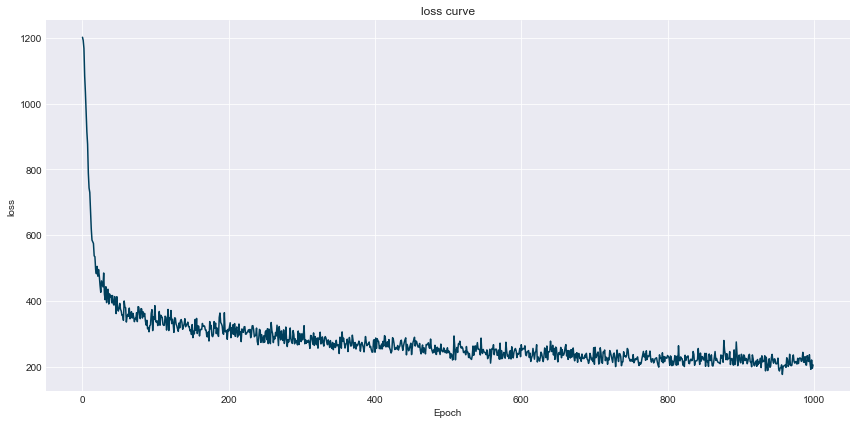

In [15]:
plot_stats(stats)

(10, 784)


Text(0.5, 0.98, 'Generated Samples')

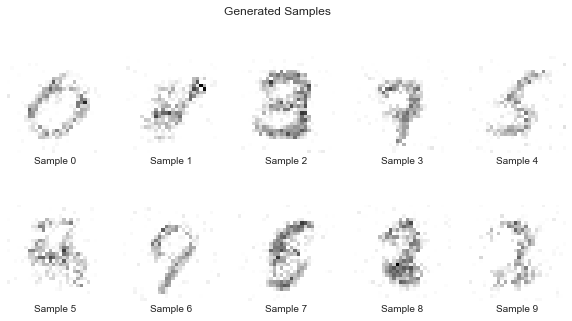

In [18]:
import matplotlib.pyplot as plt
import numpy as np

samples = model.sample(10).detach().numpy()
print(samples.shape)

plt.figure(figsize=(10, 5))
scalemax = np.abs(samples).max()
scalemin = np.abs(samples).min()


for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(samples[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.binary, vmin=scalemin, vmax=scalemax)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Sample %i' % i)
plt.suptitle('Generated Samples')

In [537]:
s.sum()

tensor(979., grad_fn=<SumBackward0>)

In [79]:
d = model.log_prob(x_train)
torch.sigmoid(d).sum()

KeyboardInterrupt: 

In [ ]:
d

In [490]:
model.num_parameters

224096

In [524]:
model.log_prob(model.sample(10))

tensor([-170.1970, -111.5485, -194.9768,  -94.3654, -320.3103, -195.1542,
        -293.7239, -227.6893, -162.1426, -215.2902], grad_fn=<SubBackward0>)